In [2]:
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import *
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
import matplotlib.pyplot as plt

from statsforecast import StatsForecast
from statsforecast.models import Naive, HistoricAverage, WindowAverage, SeasonalNaive

# 1. ARIMA sin variables exogenas
---

In [3]:
# Cargar datos de pacientes hospitalizados por día (ya procesados)
daily_counts = pd.read_csv("./data/daily_hospitalized_patients.csv")
# Parsear fechas
daily_counts['date'] = pd.to_datetime(daily_counts['date'])

# Cargar datos climáticos
# df_weather = pd.read_csv("./data/HDHI_pollution_data.csv")

In [4]:
# Preparar datos para StatsForecast
forecast_df = daily_counts.rename(columns={"date": "ds", "num_patients": "y"}).copy()
forecast_df["unique_id"] = "hospital"
forecast_df = forecast_df[["unique_id", "ds", "y"]]
forecast_df.head()


,unique_id,ds,y
0,hospital,2017-04-01,30
1,hospital,2017-04-02,45
2,hospital,2017-04-03,65
3,hospital,2017-04-04,78
4,hospital,2017-04-05,71


In [15]:
# Dividir en entrenamiento y prueba
horizon = 7
train_window = 21  #Cambia a un número de días para usar una ventana móvil (por ejemplo, 180)

if train_window is None:
    train_df = forecast_df.iloc[:-horizon].reset_index(drop=True)
else:
    if train_window <= 0:
        raise ValueError("train_window debe ser un entero positivo")
    if train_window < horizon:
        raise ValueError("train_window debe ser mayor o igual al horizonte de pronóstico")
    train_df = forecast_df.iloc[-(horizon + train_window):-horizon].reset_index(drop=True)

test_df = forecast_df.iloc[-horizon:].reset_index(drop=True)
train_df.tail(), test_df


(   unique_id         ds    y
 16  hospital 2019-03-18  165
 17  hospital 2019-03-19  186
 18  hospital 2019-03-20  176
 19  hospital 2019-03-21  168
 20  hospital 2019-03-22  177,
   unique_id         ds    y
 0  hospital 2019-03-23  164
 1  hospital 2019-03-24  152
 2  hospital 2019-03-25  171
 3  hospital 2019-03-26  151
 4  hospital 2019-03-27  159
 5  hospital 2019-03-28  170
 6  hospital 2019-03-29  174)

In [16]:
# Entrenar modelo AutoARIMA y pronosticar X días
sf = StatsForecast(models=[AutoARIMA(d=1, D=1,season_length=7)], freq="D", n_jobs=-1)
sf = sf.fit(train_df)
forecast = sf.forecast(df=train_df, h=horizon)
forecast


,unique_id,ds,AutoARIMA
0,hospital,2019-03-23,170.987656
1,hospital,2019-03-24,173.049377
2,hospital,2019-03-25,175.583328
3,hospital,2019-03-26,193.104935
4,hospital,2019-03-27,186.086426
5,hospital,2019-03-28,159.700623
6,hospital,2019-03-29,167.209869


In [17]:
# Comparar pronóstico con valores reales
comparison_df = test_df.merge(forecast, on=["unique_id", "ds"], how="left")
comparison_display = comparison_df.rename(columns={"y": "real", "AutoARIMA": "pronostico"})
comparison_display


,unique_id,ds,real,pronostico
0,hospital,2019-03-23,164,170.987656
1,hospital,2019-03-24,152,173.049377
2,hospital,2019-03-25,171,175.583328
3,hospital,2019-03-26,151,193.104935
4,hospital,2019-03-27,159,186.086426
5,hospital,2019-03-28,170,159.700623
6,hospital,2019-03-29,174,167.209869


In [18]:
# Evaluar el desempeño del modelo
metrics = evaluate(df=comparison_df, metrics=[mae, rmse, mape], models=["AutoARIMA"])
metrics


,unique_id,metric,AutoARIMA
0,hospital,mae,16.985890
1,hospital,rmse,21.285789
2,hospital,mape,0.108100


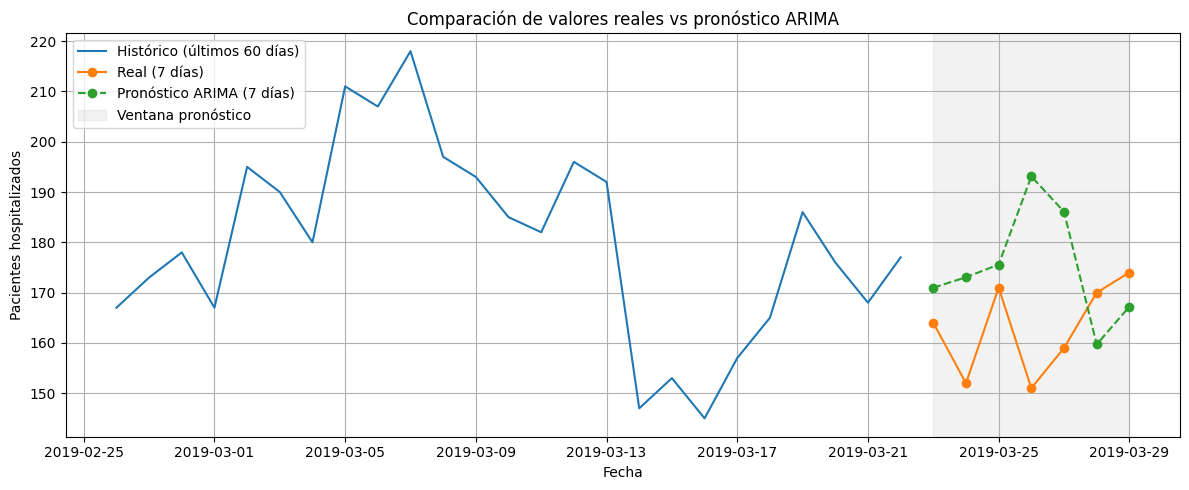

In [20]:
# Visualizar valores reales vs pronóstico
window = 25
history_df = forecast_df.iloc[-(window + horizon):-horizon]
plt.figure(figsize=(12, 5))
plt.plot(history_df["ds"], history_df["y"], label="Histórico (últimos 60 días)")
plt.plot(comparison_display["ds"], comparison_display["real"], marker="o", label="Real (7 días)")
plt.plot(comparison_display["ds"], comparison_display["pronostico"], marker="o", linestyle="--", label="Pronóstico ARIMA (7 días)")
plt.axvspan(comparison_display["ds"].min(), comparison_display["ds"].max(), color="gray", alpha=0.1, label="Ventana pronóstico")
plt.title("Comparación de valores reales vs pronóstico ARIMA")
plt.xlabel("Fecha")
plt.ylabel("Pacientes hospitalizados")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 2. SARIMA (modelo estacional)
En esta sección descomponemos la serie para analizar tendencia/estacionalidad, evaluamos ACF/PACF sobre series diferenciadas y usamos esos indicios como guía para calibrar un modelo SARIMA manual que podamos comparar con el AutoARIMA anterior.


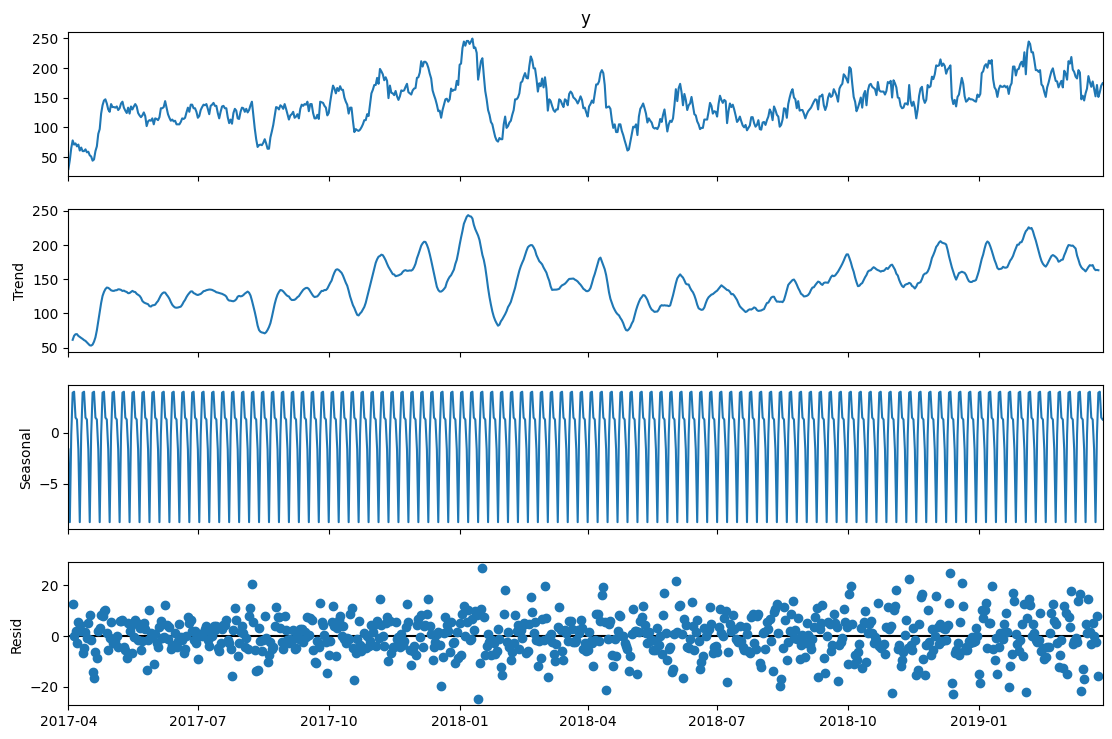

In [21]:
# Descomposición estacional para analizar la serie completa
full_series = forecast_df.set_index("ds")["y"].astype(float)
decomposition = seasonal_decompose(full_series, model="additive", period=7)
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()


In [22]:
# Preparar series diferenciadas para ACF/PACF
# Diferenciación regular (d=1)
diff_series = full_series.diff().dropna()
# Diferenciación estacional (D=1 con periodo 7)
diff_seasonal_series = diff_series.diff(7).dropna()

diff_series.head(), diff_seasonal_series.head()


(ds
 2017-04-02    15.0
 2017-04-03    20.0
 2017-04-04    13.0
 2017-04-05    -7.0
 2017-04-06     2.0
 Name: y, dtype: float64,
 ds
 2017-04-09   -25.0
 2017-04-10   -15.0
 2017-04-11   -19.0
 2017-04-12     7.0
 2017-04-13     1.0
 Name: y, dtype: float64)

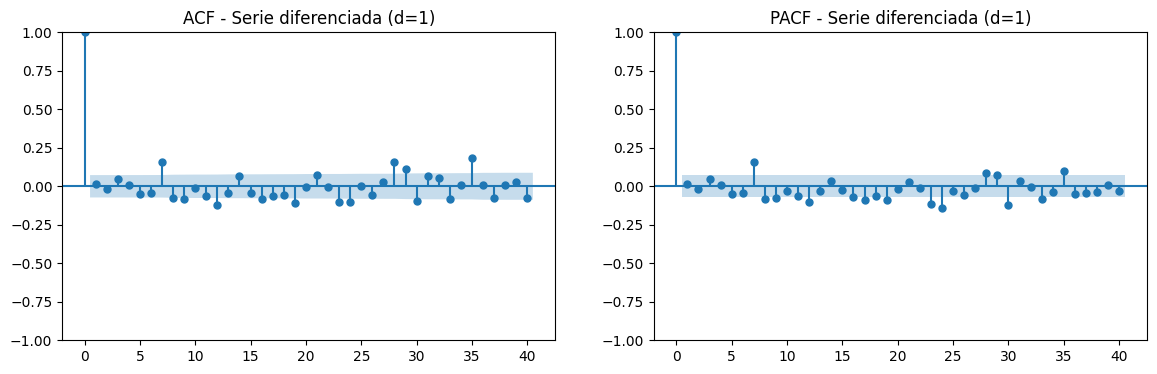

In [23]:
# Correlograma ACF/PACF para la serie con diferenciación regular
defined_lags = 40
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(diff_series, lags=defined_lags, ax=axes[0])
plot_pacf(diff_series, lags=defined_lags, ax=axes[1])
axes[0].set_title("ACF - Serie diferenciada (d=1)")
axes[1].set_title("PACF - Serie diferenciada (d=1)")
plt.show()


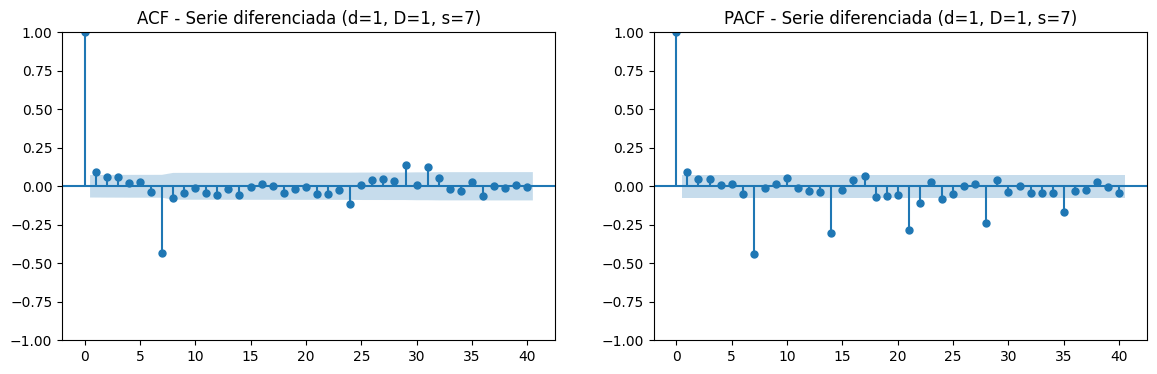

In [24]:
# Correlograma ACF/PACF para la serie con diferenciación regular y estacional
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(diff_seasonal_series, lags=defined_lags, ax=axes[0])
plot_pacf(diff_seasonal_series, lags=defined_lags, ax=axes[1])
axes[0].set_title("ACF - Serie diferenciada (d=1, D=1, s=7)")
axes[1].set_title("PACF - Serie diferenciada (d=1, D=1, s=7)")
plt.show()


In [25]:
# Preparar conjuntos de entrenamiento y prueba para SARIMA
sarima_train = train_df.set_index("ds")["y"].astype(float)
sarima_test = test_df.set_index("ds")["y"].astype(float)
sarima_train.tail(), sarima_test


(ds
 2019-03-18    165.0
 2019-03-19    186.0
 2019-03-20    176.0
 2019-03-21    168.0
 2019-03-22    177.0
 Name: y, dtype: float64,
 ds
 2019-03-23    164.0
 2019-03-24    152.0
 2019-03-25    171.0
 2019-03-26    151.0
 2019-03-27    159.0
 2019-03-28    170.0
 2019-03-29    174.0
 Name: y, dtype: float64)

In [26]:
# Diccionario para guardar combinaciones candidatas basadas en los gráficos
candidate_orders = [
    {"order": (1, 1, 1), "seasonal_order": (1, 1, 1, 7)},
    {"order": (2, 1, 1), "seasonal_order": (1, 1, 1, 7)},
    {"order": (1, 1, 2), "seasonal_order": (1, 1, 1, 7)},
]

candidate_orders


[{'order': (1, 1, 1), 'seasonal_order': (1, 1, 1, 7)},
 {'order': (2, 1, 1), 'seasonal_order': (1, 1, 1, 7)},
 {'order': (1, 1, 2), 'seasonal_order': (1, 1, 1, 7)}]

In [27]:
# Evaluar combinaciones candidatas mediante AIC
best_aic = np.inf
best_cfg = None
best_results = None

for cfg in candidate_orders:
    try:
        model = SARIMAX(
            sarima_train,
            order=cfg["order"],
            seasonal_order=cfg["seasonal_order"],
            enforce_stationarity=False,
            enforce_invertibility=False,
        )
        results = model.fit(disp=False)
        if results.aic < best_aic:
            best_aic = results.aic
            best_cfg = cfg
            best_results = results
    except Exception as e:
        print(f"Error con configuración {cfg}: {e}")

best_cfg, best_aic


c:\Users\Gaby\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Gaby\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Gaby\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Gaby\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Gaby\AppData\Local\Programs\Python\Python311\Lib\site-p

({'order': (1, 1, 2), 'seasonal_order': (1, 1, 1, 7)}, 5214.884294976545)

In [28]:
# Ajustar el modelo SARIMA con la mejor configuración
debug_best_cfg = best_cfg or {"order": (1, 1, 1), "seasonal_order": (1, 1, 1, 7)}
print("Configuración seleccionada:", debug_best_cfg)

sarima_model = SARIMAX(
    sarima_train,
    order=debug_best_cfg["order"],
    seasonal_order=debug_best_cfg["seasonal_order"],
    enforce_stationarity=False,
    enforce_invertibility=False,
)
sarima_results = sarima_model.fit(disp=False)
sarima_results.summary()


Configuración seleccionada: {'order': (1, 1, 2), 'seasonal_order': (1, 1, 1, 7)}


c:\Users\Gaby\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Gaby\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  700
Model:             SARIMAX(1, 1, 2)x(1, 1, [1], 7)   Log Likelihood               -2601.442
Date:                             Tue, 11 Nov 2025   AIC                           5214.884
Time:                                     21:38:38   BIC                           5242.034
Sample:                                 04-22-2017   HQIC                          5225.392
                                      - 03-22-2019                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5703      0.335      1.701      0.089      -0.087       1.227
ma.L1         -0.5703      0.337     -1.690      0.091      -1.232       0.091
ma.L2          0.0609      0.039      1.577      0.115      -0.015       0.137
ar.S.L7        0.0012      0.041      0.028      0.978      -0.080       0.082
ma.S.L7       -1.0000     30.679     -0.033      0.974     -61.130      59.130
sigma2       115.7487   3552.771      0.033      0.974   -6847.554    7079.051
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                81.54
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               2.47   Skew:                            -0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
# Pronosticar los próximos 7 días con SARIMA
sarima_forecast_res = sarima_results.get_forecast(steps=horizon)
sarima_mean = sarima_forecast_res.predicted_mean
sarima_conf_int = sarima_forecast_res.conf_int()

sarima_forecast = (
    sarima_mean.rename("sarima_pronostico")
    .to_frame()
    .reset_index()
    .rename(columns={"index": "ds"})
)
sarima_forecast


,ds,sarima_pronostico
0,2019-03-23,173.563078
1,2019-03-24,166.840312
2,2019-03-25,175.607244
3,2019-03-26,180.206682
4,2019-03-27,180.380390
5,2019-03-28,177.737394
6,2019-03-29,177.720269


In [30]:
# Comparar SARIMA vs observaciones reales
sarima_comparison = (
    test_df.merge(sarima_forecast, on="ds", how="left")
    .rename(columns={"y": "real"})
)
sarima_comparison


,unique_id,ds,real,sarima_pronostico
0,hospital,2019-03-23,164,173.563078
1,hospital,2019-03-24,152,166.840312
2,hospital,2019-03-25,171,175.607244
3,hospital,2019-03-26,151,180.206682
4,hospital,2019-03-27,159,180.380390
5,hospital,2019-03-28,170,177.737394
6,hospital,2019-03-29,174,177.720269


In [31]:
# Métricas para SARIMA
sarima_errors = sarima_comparison["real"] - sarima_comparison["sarima_pronostico"]
mae_sarima = sarima_errors.abs().mean()
rmse_sarima = np.sqrt((sarima_errors ** 2).mean())
mape_sarima = (sarima_errors.abs() / sarima_comparison["real"].replace(0, np.nan)).mean() * 100

pd.DataFrame(
    {
        "modelo": ["SARIMA"],
        "MAE": [mae_sarima],
        "RMSE": [rmse_sarima],
        "MAPE (%)": [mape_sarima],
    }
)


,modelo,MAE,RMSE,MAPE (%)
0,SARIMA,13.00791,15.660565,8.252465


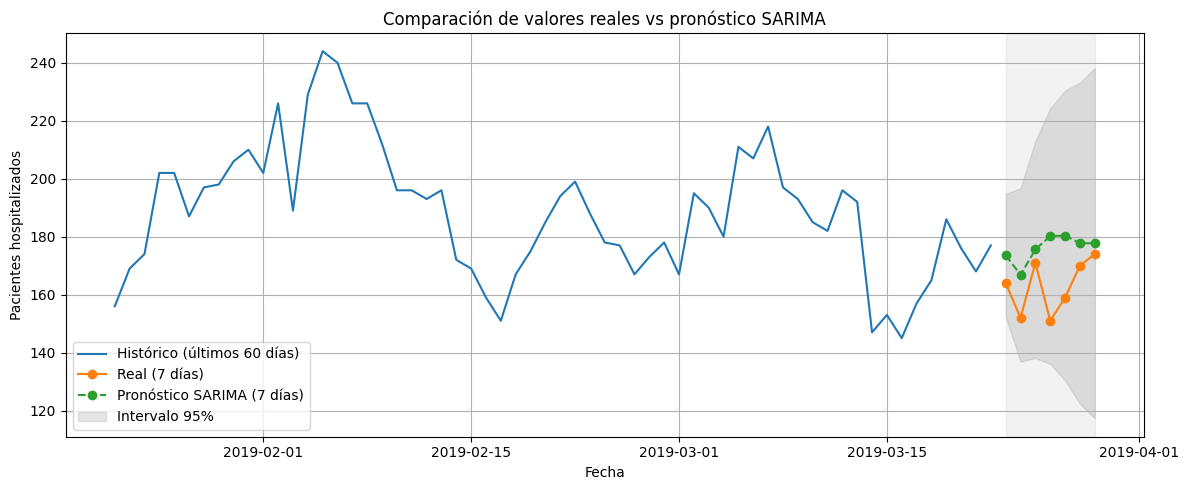

In [32]:
# Visualizar comparación SARIMA
plt.figure(figsize=(12, 5))
plt.plot(history_df["ds"], history_df["y"], label="Histórico (últimos 60 días)")
plt.plot(sarima_comparison["ds"], sarima_comparison["real"], marker="o", label="Real (7 días)")
plt.plot(
    sarima_comparison["ds"],
    sarima_comparison["sarima_pronostico"],
    marker="o",
    linestyle="--",
    label="Pronóstico SARIMA (7 días)",
)
plt.fill_between(
    sarima_forecast_res.conf_int().index,
    sarima_conf_int.iloc[:, 0],
    sarima_conf_int.iloc[:, 1],
    color="gray",
    alpha=0.2,
    label="Intervalo 95%",
)
plt.axvspan(sarima_comparison["ds"].min(), sarima_comparison["ds"].max(), color="gray", alpha=0.1)
plt.title("Comparación de valores reales vs pronóstico SARIMA")
plt.xlabel("Fecha")
plt.ylabel("Pacientes hospitalizados")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 3. Validación cruzada temporal
Para evaluar la estabilidad de los modelos implementamos una validación cruzada tipo *rolling-origin* tanto para AutoARIMA como para SARIMA.


In [33]:
# Configuración del backtesting
cv_horizon = 7
cv_windows = 5
cv_step = 7  # días entre cada corte
print(f"Validación cruzada temporal: horizonte={cv_horizon}, ventanas={cv_windows}, paso={cv_step}")


Validación cruzada temporal: horizonte=7, ventanas=5, paso=7


In [34]:
# Backtesting con StatsForecast (AutoARIMA)
sf_cv = StatsForecast(models=[AutoARIMA(season_length=7)], freq="D", n_jobs=-1)
autoarima_cv = sf_cv.cross_validation(
    df=forecast_df,
    h=cv_horizon,
    step_size=cv_step,
    n_windows=cv_windows,
)
autoarima_cv.head()


,unique_id,ds,cutoff,y,AutoARIMA
0,hospital,2019-02-23,2019-02-22,188.0,196.773895
1,hospital,2019-02-24,2019-02-22,178.0,194.440933
2,hospital,2019-02-25,2019-02-22,177.0,197.278915
3,hospital,2019-02-26,2019-02-22,167.0,198.521072
4,hospital,2019-02-27,2019-02-22,173.0,200.469910


In [35]:
# Métricas promedio de AutoARIMA en cross validation
autoarima_cv_metrics = evaluate(
    df=autoarima_cv,
    metrics=[mae, rmse, mape],
    models=["AutoARIMA"],
)
autoarima_cv_metrics


,unique_id,metric,AutoARIMA
0,hospital,mae,24.225620
1,hospital,rmse,28.092035
2,hospital,mape,0.137450


In [36]:
# Backtesting manual para SARIMA usando la mejor configuración encontrada
sarima_series = forecast_df.set_index("ds")["y"].astype(float)
sarima_cv_results = []

if "debug_best_cfg" not in globals() or debug_best_cfg is None:
    raise ValueError("No se identificó una configuración óptima para SARIMA. Ejecuta primero las celdas de ajuste.")

for window in range(cv_windows):
    cutoff_idx = len(sarima_series) - (cv_windows - window) * cv_step
    train_slice = sarima_series.iloc[:cutoff_idx]
    test_slice = sarima_series.iloc[cutoff_idx:cutoff_idx + cv_horizon]

    if len(test_slice) < cv_horizon or len(train_slice) == 0:
        continue

    model = SARIMAX(
        train_slice,
        order=debug_best_cfg["order"],
        seasonal_order=debug_best_cfg["seasonal_order"],
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    res = model.fit(disp=False)
    preds = res.forecast(steps=cv_horizon)

    window_df = pd.DataFrame(
        {
            "unique_id": "hospital",
            "ds": test_slice.index,
            "cutoff": train_slice.index[-1],
            "y": test_slice.values,
            "SARIMA": preds.values,
        }
    )
    sarima_cv_results.append(window_df)

sarima_cv = pd.concat(sarima_cv_results, ignore_index=True)
sarima_cv.head()


c:\Users\Gaby\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Gaby\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Gaby\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Gaby\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Gaby\AppData\Local\Programs\Python\Python311\Lib\site-p

,unique_id,ds,cutoff,y,SARIMA
0,hospital,2019-02-23,2019-02-22,188.0,197.571460
1,hospital,2019-02-24,2019-02-22,178.0,191.511252
2,hospital,2019-02-25,2019-02-22,177.0,201.202411
3,hospital,2019-02-26,2019-02-22,167.0,205.593854
4,hospital,2019-02-27,2019-02-22,173.0,206.063657


In [37]:
# Métricas promedio de SARIMA en cross validation
sarima_cv_metrics = evaluate(
    df=sarima_cv,
    metrics=[mae, rmse, mape],
    models=["SARIMA"],
)
sarima_cv_metrics


,unique_id,metric,SARIMA
0,hospital,mae,22.697709
1,hospital,rmse,26.845228
2,hospital,mape,0.129016


In [38]:
# Resumen comparativo de validación cruzada
cv_summary = pd.concat(
    [autoarima_cv_metrics.assign(modelo="AutoARIMA"), sarima_cv_metrics.assign(modelo="SARIMA")],
    ignore_index=True,
)
cv_summary


,unique_id,metric,AutoARIMA,modelo,SARIMA
0,hospital,mae,24.225620,AutoARIMA,NaN
1,hospital,rmse,28.092035,AutoARIMA,NaN
2,hospital,mape,0.137450,AutoARIMA,NaN
3,hospital,mae,NaN,SARIMA,22.697709
4,hospital,rmse,NaN,SARIMA,26.845228
5,hospital,mape,NaN,SARIMA,0.129016


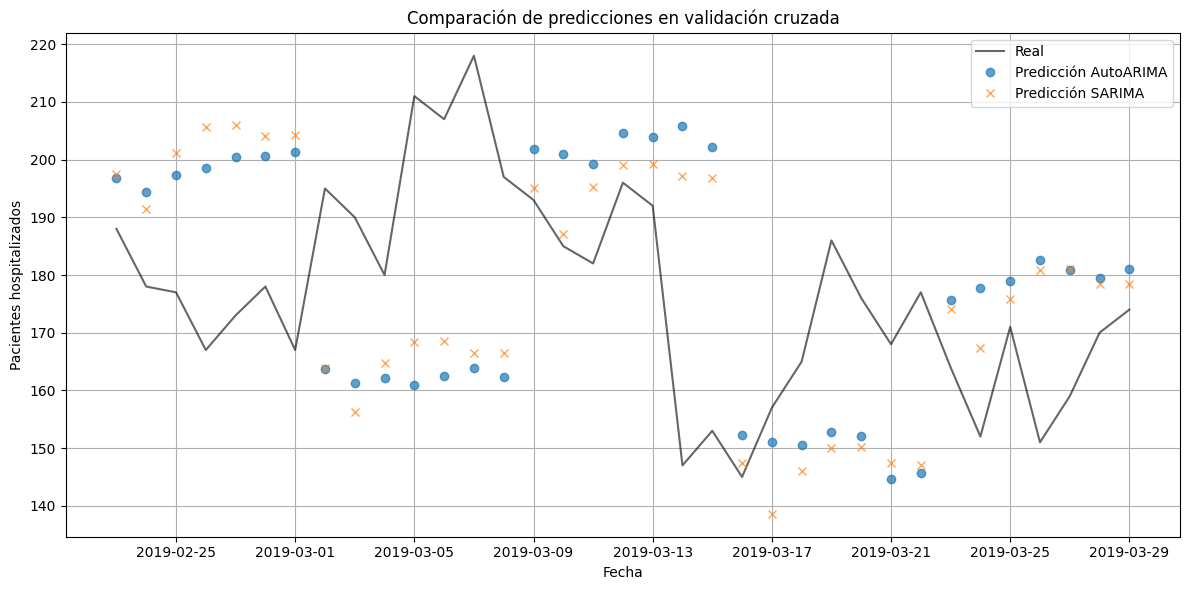

In [39]:
# Gráfica comparativa de cross validation (AutoARIMA vs SARIMA)
def plot_cv_comparison(auto_cv: pd.DataFrame, sarima_cv: pd.DataFrame):
    plt.figure(figsize=(12, 6))
    plt.plot(auto_cv["ds"], auto_cv["y"], label="Real", color="black", alpha=0.6)
    plt.plot(auto_cv["ds"], auto_cv["AutoARIMA"], "o", label="Predicción AutoARIMA", alpha=0.7)
    plt.plot(sarima_cv["ds"], sarima_cv["SARIMA"], "x", label="Predicción SARIMA", alpha=0.7)
    plt.title("Comparación de predicciones en validación cruzada")
    plt.xlabel("Fecha")
    plt.ylabel("Pacientes hospitalizados")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_cv_comparison(autoarima_cv, sarima_cv)
